In [23]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from pathlib import Path

import plotly.figure_factory as ff
import plotly.io as pio

import sklearn
from sklearn import set_config
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.multiclass import OneVsRestClassifier
# from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import average_precision_score, precision_recall_curve

import spacy
from spacy.lang.en import STOP_WORDS

import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
nli_train = pd.read_csv('TOEFL-train-tagged-readability.csv')
nli_test = pd.read_csv('TOEFL-test-tagged-readability.csv')

icle = pd.read_csv('icle_toefl_tagged_readability.csv')

In [4]:
nli_train.head()

,Unnamed: 0,Filename,text,Language,Proficiency,pos,readability_words,readability_sents
0,0,88.txt,Some people might think that traveling in a gr...,KOR,high,DET NOUN AUX VERB SCONJ VERB ADP DET NOUN VERB...,3.695962,23.388889
1,1,278.txt,IThe importance and popularity of travelling i...,DEU,medium,DET NOUN CCONJ NOUN ADP VERB AUX ADV VERB PUNC...,3.829480,23.066667
2,2,348.txt,"It is an important decision, how to plan your ...",TUR,high,PRON AUX DET ADJ NOUN PUNCT SCONJ PART VERB PR...,4.126551,25.187500
3,3,666.txt,Some people believe that young people can enjo...,ZHO,medium,DET NOUN VERB SCONJ ADJ NOUN AUX VERB NOUN ADJ...,3.812808,15.037037
4,4,733.txt,Travelling is usually considered as good recr...,TEL,medium,NOUN AUX SPACE ADV VERB ADP ADJ NOUN SPACE ADP...,4.072581,26.571429


In [5]:
icle.head()

,Unnamed: 0.1,Unnamed: 0,File_name,Native_language,Country,Gender,Age,1st_FL,2nd_FL,3rd_FL,...,Length_in_words,Type,Conditions,Reference_tools,Examination,Comments,Text,pos,readability_words,readability_sents
0,0,0,FRUC2027,FRA,Belgium,Female,21.0,Dutch,NaN,NaN,...,896,Literary,Timed,Yes,Yes,-,Different ways of managing kinds of wastes ar...,SPACE ADJ NOUN ADP VERB NOUN ADP NOUN AUX VERB...,4.380634,20.655172
1,1,1,FRUC2028,FRA,Belgium,Female,20.0,NaN,NaN,NaN,...,657,Literary,Timed,Yes,Yes,-,"Nowadays, people around the world pay more at...",SPACE ADV PUNCT NOUN ADP DET NOUN VERB ADJ NOU...,4.502755,22.000000
2,2,2,FRUC2029,FRA,Belgium,Female,22.0,German,Dutch,NaN,...,712,Literary,Timed,Yes,Yes,-,There are a million of trush produced by Hong...,SPACE PRON VERB DET NUM ADP NOUN VERB ADP PROP...,4.303290,16.642857
3,3,3,FRUC2030,FRA,Belgium,Female,21.0,Dutch,NaN,NaN,...,652,Literary,Timed,Yes,Yes,-,"In Hong Kong, majority of waste management is...",SPACE ADP PROPN PROPN PUNCT NOUN ADP NOUN NOUN...,4.421898,20.147059
4,4,4,FRUC2032,FRA,Belgium,Female,20.0,Dutch,NaN,NaN,...,1870,Literary,Timed,Yes,Yes,-,There are various way for treating waste mate...,SPACE PRON VERB ADJ NOUN ADP VERB NOUN NOUN AD...,4.519525,18.406250


In [6]:
desired_languages = ['JPN', 'DEU', 'KOR', 'ZHO', 'SPA', 'TUR', 'ITA', 'FRA']
nli_train = nli_train[nli_train['Language'].isin(desired_languages)]
nli_test = nli_test[nli_test['Language'].isin(desired_languages)]

In [7]:
nli_train.text.replace(r'\n+',' ', regex=True, inplace=True)
nli_test.text.replace(r'\n+', ' ', regex=True, inplace=True)
icle.Text.replace(r'\n+', ' ', regex=True, inplace=True)

In [8]:
X_train = nli_train.drop(columns=['Unnamed: 0', 'Filename', 'Language', 'Proficiency'])
y_train = nli_train.Language
X_test = nli_test.drop(columns=['Unnamed: 0','Filename', 'Language', 'Proficiency'])
y_test = nli_test.Language
X_icle = icle.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'File_name', 'Native_language', 'Country', 'Gender', 'Age', '1st_FL', '2nd_FL', '3rd_FL', '1st_Lhome',
                     '2nd_Lhome', '3rd_Lhome', 'Years_Eng_school', 'Years_Eng_uni','Months_in_Eng_country', 'Institution',
                     'Topic', 'Length_in_words', 'Type', 'Conditions', 'Reference_tools', 'Examination', 'Comments'])
X_icle = X_icle.rename(columns={'Text':'text'})
y_icle = icle.Native_language
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_icle.shape, y_icle.shape

((8000, 4), (8000,), (800, 4), (800,), (3441, 4), (3441,))

## Logistic Regression + NLP  features

In [9]:
# Now integrate the other information sources

# we will scale the numeric features
scaler = StandardScaler()

# we will use a bag of word pattern vecorizer for the text and another one for the pos tags
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer= str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1,4), lowercase=False, tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
    (scaler, ['readability_words','readability_sents']), # we scale the numeric features
    (vect1, 'text'), # uni and bigrams bag of words
    (vect2, 'pos'), # up to 4-grams for pos patterns (fewer different patterns)
    remainder = 'drop')
clf = LogisticRegression(random_state=42, max_iter=1000)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['readability_words',
                                                   'readability_sents']),
                                                 ('tfidfvectorizer-1',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=200,
                                                                  ngram_range=(1,
                                                                               4),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'pos')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

### TOEFL in-corpus LogReg + NLP

              precision    recall  f1-score   support

         DEU       0.85      0.87      0.86       100
         FRA       0.74      0.75      0.75       100
         ITA       0.82      0.78      0.80       100
         JPN       0.79      0.79      0.79       100
         KOR       0.74      0.74      0.74       100
         SPA       0.73      0.69      0.71       100
         TUR       0.74      0.76      0.75       100
         ZHO       0.75      0.78      0.76       100

    accuracy                           0.77       800
   macro avg       0.77      0.77      0.77       800
weighted avg       0.77      0.77      0.77       800



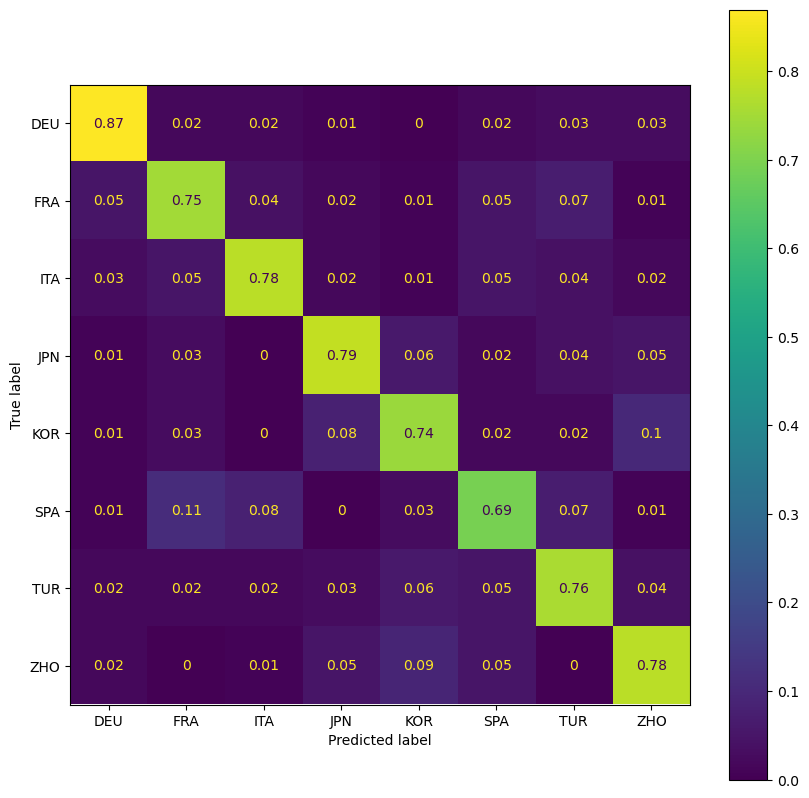

In [11]:
y_test_pred = pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

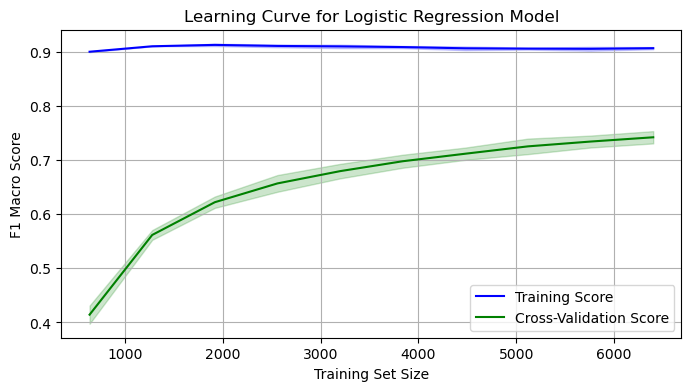

In [17]:
# Generate a learning curve
train_sizes, train_scores, test_scores = learning_curve(
    pipe, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)

plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

plt.title('Learning Curve for Logistic Regression on TOEFL')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Macro Score')
plt.legend()
plt.grid(True)
plt.show()

### ICLE cross-corpus LogReg + NLP

              precision    recall  f1-score   support

         DEU       0.73      0.50      0.60       445
         FRA       0.41      0.83      0.55       314
         ITA       0.65      0.59      0.62       398
         JPN       0.90      0.57      0.70       366
         KOR       0.57      0.66      0.61       400
         SPA       0.53      0.44      0.48       250
         TUR       0.45      0.85      0.59       286
         ZHO       0.87      0.61      0.72       982

    accuracy                           0.62      3441
   macro avg       0.64      0.63      0.61      3441
weighted avg       0.69      0.62      0.63      3441



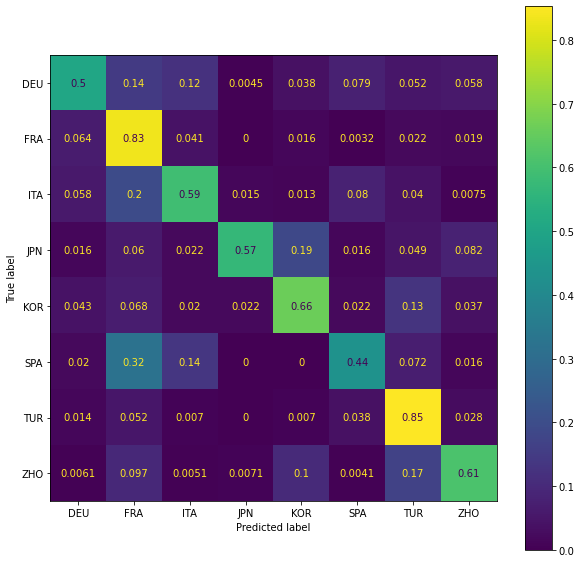

In [11]:
y_test_icle_pred = pipe.predict(X_icle)

print(classification_report(y_icle, y_test_icle_pred))

cm = confusion_matrix(y_icle, y_test_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Logistic Regression + NLP - POS

In [12]:
scaler = StandardScaler()

# we will use a bag of word pattern vecorizer for the text and another one for the pos tags
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer= str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1,4), lowercase=False, tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
    (scaler, ['readability_words','readability_sents']), 
    (vect1, 'text'), 
#    (vect2, 'pos'), 
    remainder = 'drop')
clf = LogisticRegression(random_state=42, max_iter=1000)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['readability_words',
                                                   'readability_sents']),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=

### TOEFL in-corpus LogReg + NLP - POS

              precision    recall  f1-score   support

         DEU       0.84      0.90      0.87       100
         FRA       0.74      0.72      0.73       100
         ITA       0.80      0.72      0.76       100
         JPN       0.73      0.76      0.75       100
         KOR       0.71      0.70      0.70       100
         SPA       0.67      0.69      0.68       100
         TUR       0.74      0.73      0.73       100
         ZHO       0.74      0.75      0.75       100

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



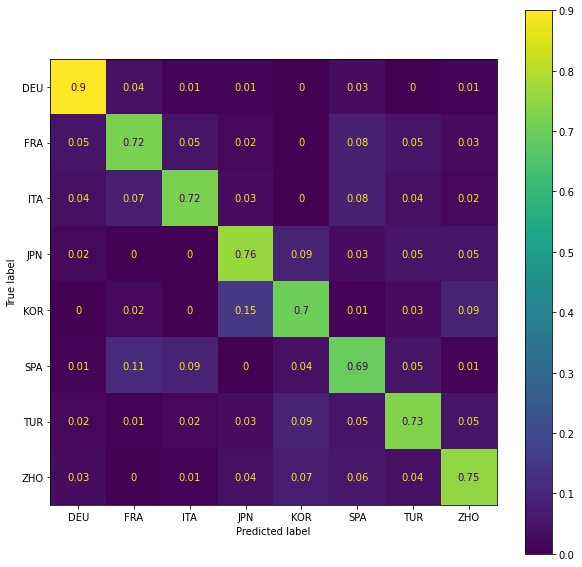

In [13]:
y_test_pred = pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### ICLE cross-corpus LogReg + NLP - POS

              precision    recall  f1-score   support

         DEU       0.61      0.53      0.57       445
         FRA       0.42      0.77      0.54       314
         ITA       0.57      0.67      0.62       398
         JPN       0.89      0.56      0.68       366
         KOR       0.65      0.57      0.61       400
         SPA       0.53      0.40      0.46       250
         TUR       0.44      0.85      0.58       286
         ZHO       0.90      0.63      0.74       982

    accuracy                           0.62      3441
   macro avg       0.63      0.62      0.60      3441
weighted avg       0.69      0.62      0.63      3441



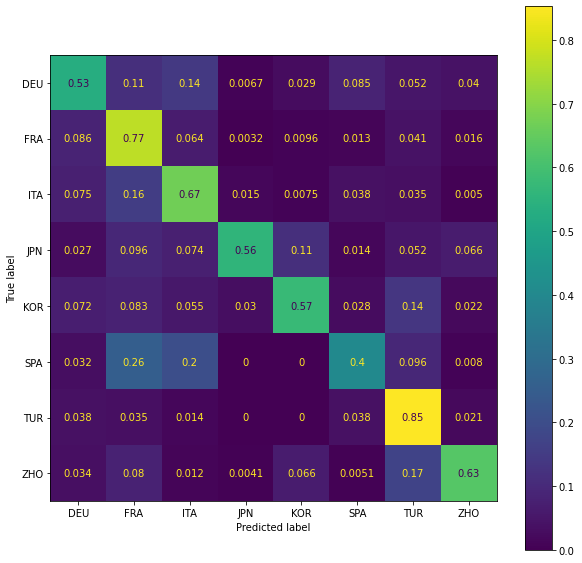

In [14]:
y_test_icle_pred = pipe.predict(X_icle)

print(classification_report(y_icle, y_test_icle_pred))

cm = confusion_matrix(y_icle, y_test_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Logistic Regression + NLP - Complexity 

In [30]:
scaler = StandardScaler()

# we will use a bag of word pattern vecorizer for the text and another one for the pos tags
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer= str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1,4), lowercase=False, tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
#    (scaler, ['readability_words','readability_sents']), 
    (vect1, 'text'), 
    (vect2, 'pos'), 
    remainder = 'drop')
clf = LogisticRegression(random_state=42, max_iter=1000)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=200,
                                                                  ngram_range=(1,
                                                                               4),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'pos')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

### TOEFL in-corpus LogReg + NLP - Complexity

              precision    recall  f1-score   support

         DEU       0.83      0.91      0.87       100
         FRA       0.77      0.78      0.78       100
         ITA       0.85      0.78      0.81       100
         JPN       0.74      0.78      0.76       100
         KOR       0.76      0.77      0.77       100
         SPA       0.76      0.67      0.71       100
         TUR       0.74      0.75      0.75       100
         ZHO       0.76      0.78      0.77       100

    accuracy                           0.78       800
   macro avg       0.78      0.78      0.78       800
weighted avg       0.78      0.78      0.78       800



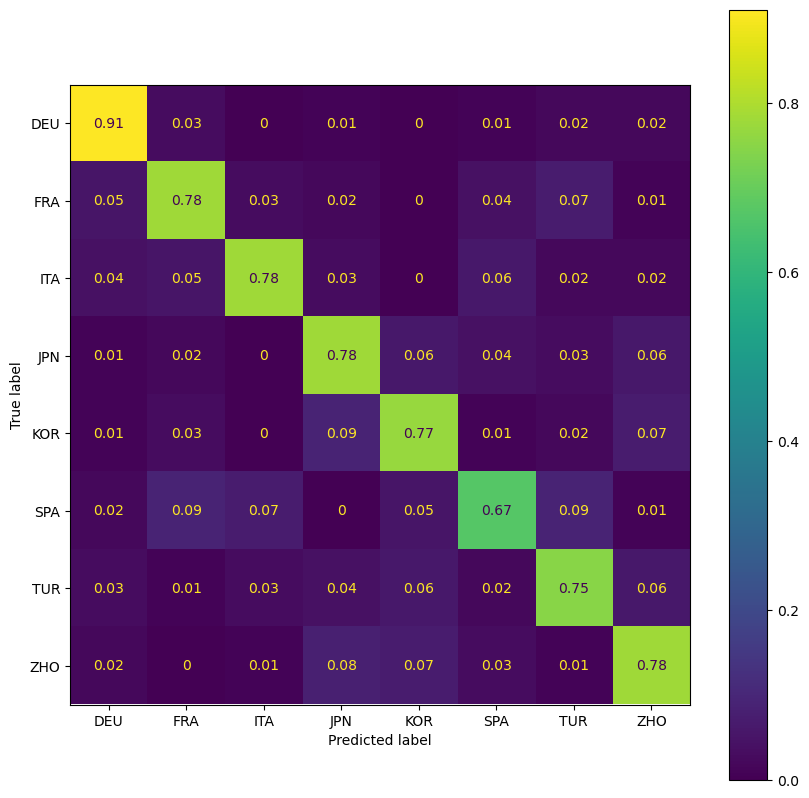

In [31]:
y_test_pred = pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

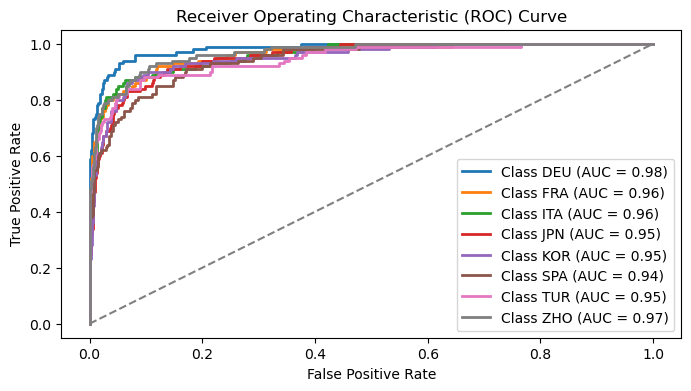

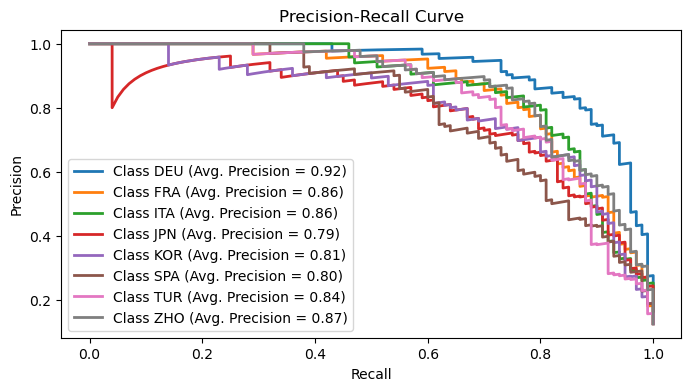

In [32]:
# Fit the model
pipe.fit(X_train, y_train)

# Get prediction probabilities for ROC and Precision-Recall plots
y_prob = pipe.predict_proba(X_test)

# Binarize the true labels for multi-class evaluation
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plot ROC Curves
plt.figure(figsize=(8, 4))
for i in range(y_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {lb.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curves
plt.figure(figsize=(8, 4))
for i in range(y_prob.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {lb.classes_[i]} (Avg. Precision = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### ICLE cross-corpus LogReg + NLP - Complexity

              precision    recall  f1-score   support

         DEU       0.76      0.51      0.61       445
         FRA       0.39      0.84      0.53       314
         ITA       0.64      0.60      0.62       398
         JPN       0.89      0.55      0.68       366
         KOR       0.60      0.64      0.62       400
         SPA       0.49      0.40      0.44       250
         TUR       0.50      0.84      0.62       286
         ZHO       0.86      0.66      0.74       982

    accuracy                           0.63      3441
   macro avg       0.64      0.63      0.61      3441
weighted avg       0.69      0.63      0.64      3441



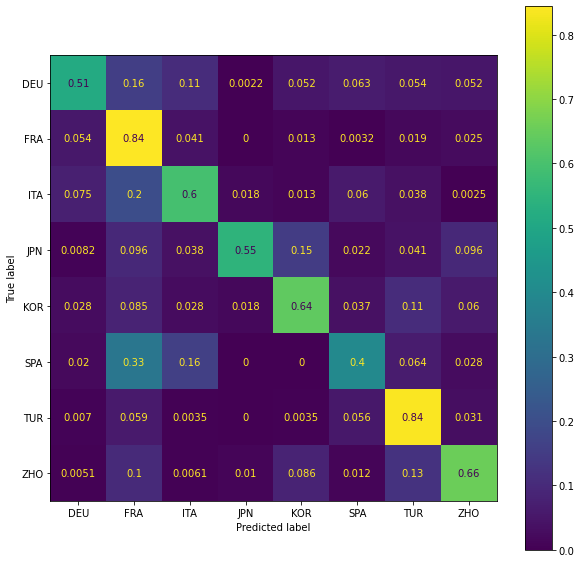

In [17]:
y_test_icle_pred = pipe.predict(X_icle)

print(classification_report(y_icle, y_test_icle_pred))

cm = confusion_matrix(y_icle, y_test_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Logistic Regression - NLP

In [26]:
scaler = StandardScaler()

# we will use a bag of word pattern vecorizer for the text and another one for the pos tags
vect1 = TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer= str.split)
vect2 = TfidfVectorizer(max_features=200, ngram_range=(1,4), lowercase=False, tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
#     (scaler, ['readability_words','readability_sents']), 
    (vect1, 'text'), 
#     (vect2, 'pos'), 
    remainder = 'drop')
clf = LogisticRegression(random_state=42, max_iter=1000)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

### TOEFL in-corpus LogReg - NLP

              precision    recall  f1-score   support

         DEU       0.83      0.90      0.86       100
         FRA       0.77      0.77      0.77       100
         ITA       0.75      0.73      0.74       100
         JPN       0.72      0.76      0.74       100
         KOR       0.76      0.71      0.73       100
         SPA       0.70      0.67      0.68       100
         TUR       0.76      0.74      0.75       100
         ZHO       0.76      0.77      0.77       100

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.76       800
weighted avg       0.76      0.76      0.76       800



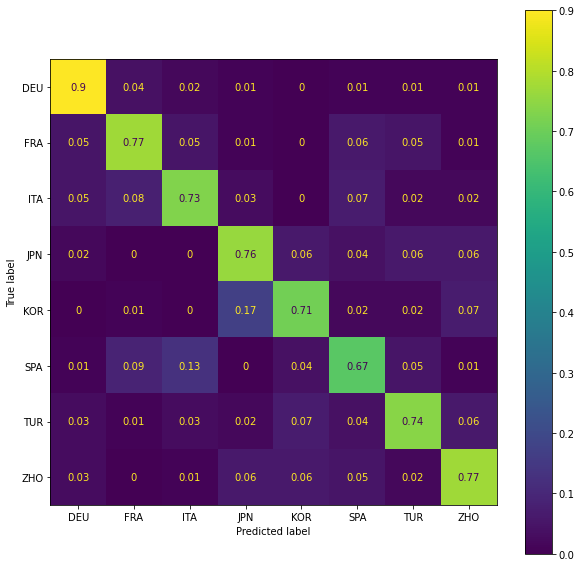

In [19]:
y_test_pred = pipe.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### ICLE cross-corpus LogReg - NLP

              precision    recall  f1-score   support

         DEU       0.70      0.55      0.61       445
         FRA       0.40      0.78      0.53       314
         ITA       0.52      0.67      0.59       398
         JPN       0.86      0.53      0.65       366
         KOR       0.70      0.51      0.59       400
         SPA       0.48      0.42      0.45       250
         TUR       0.52      0.83      0.64       286
         ZHO       0.90      0.72      0.80       982

    accuracy                           0.64      3441
   macro avg       0.64      0.62      0.61      3441
weighted avg       0.70      0.64      0.65      3441



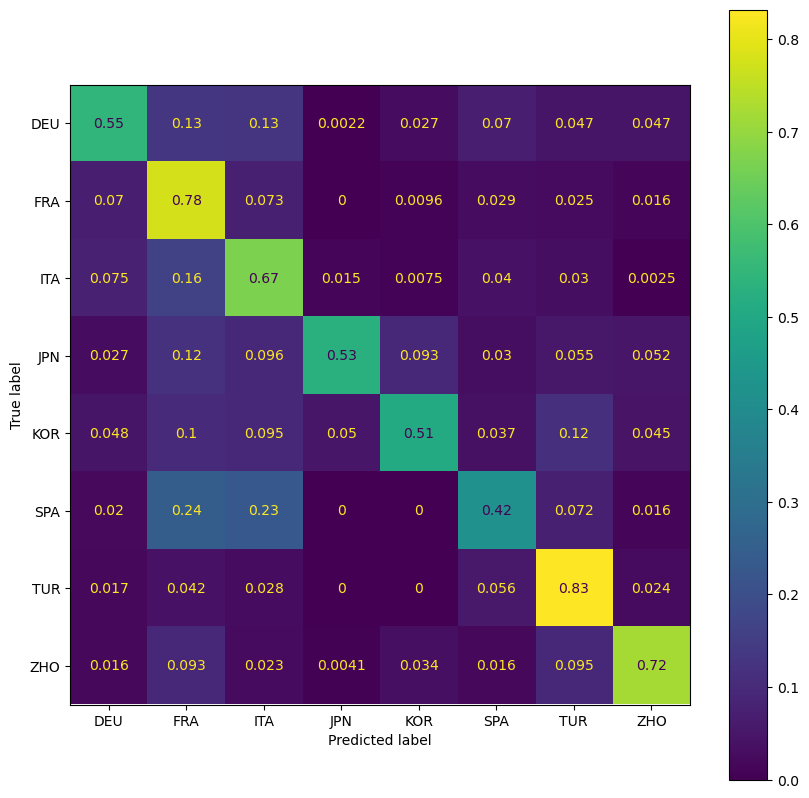

In [27]:
y_test_icle_pred = pipe.predict(X_icle)

print(classification_report(y_icle, y_test_icle_pred))

cm = confusion_matrix(y_icle, y_test_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

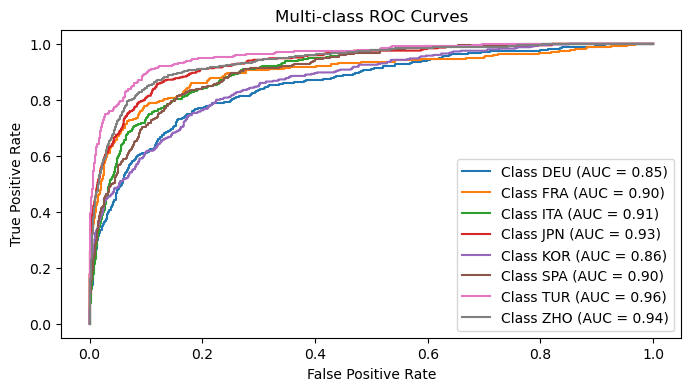

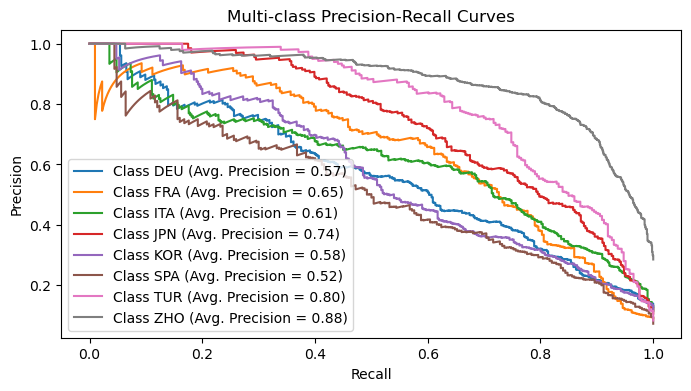

In [29]:
# Binarize the labels for multi-class evaluation
y_train_bin = label_binarize(y_train, classes=pipe.classes_)
y_icle_bin = label_binarize(y_icle, classes=pipe.classes_)
n_classes = y_train_bin.shape[1]

# Train a OneVsRestClassifier with the pipeline
ovr_clf = OneVsRestClassifier(pipe)
ovr_clf.fit(X_train, y_train_bin)

# Predict probabilities for the ICLE test set
y_prob = ovr_clf.predict_proba(X_icle)

# Plotting ROC curves for each class
plt.figure(figsize=(8, 4))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_icle_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {pipe.classes_[i]} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='best')
plt.show()

# Plotting Precision-Recall curves for each class
plt.figure(figsize=(8, 4))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_icle_bin[:, i], y_prob[:, i])
    avg_precision = average_precision_score(y_icle_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f'Class {pipe.classes_[i]} (Avg. Precision = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curves')
plt.legend(loc='best')
plt.show()